<a href="https://colab.research.google.com/github/Victorious3/vanila-gan/blob/master/Generative_Adversarial_Networks_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Example

In [59]:
!pip install tensorboardX
from utils import Logger

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
import torchvision
from torchvision import transforms
from torchvision.transforms import  ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
import numpy
from utils import Logger
...

Ellipsis

## Dataset
To simplify, the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. Test Change The data will be saved into a folder called `MNIST_data`. 

In [61]:

MNIST_data = torchvision.datasets.MNIST(
    root='./data/MNIST_data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5) ) ] )
)

MNIST_loader = torch.utils.data.DataLoader(
    MNIST_data, batch_size=64, shuffle=True
)

# checking if loaded data is transformed to a tensor with values from -1 to 1

img, label = MNIST_data[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)



Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`. Implement `sample_noise` Hint: use `torch.rand`. Make sure noise is the correct shape and type:

In [62]:

def sample_noise(batch_size, dim): 
  n = Variable(torch.rand(batch_size, dim) + torch.rand(batch_size, dim)*(-1))
  if torch.cuda.is_available(): 
    return n.cuda() 
  return n
 
sample_noise(5000,128)

tensor([[-0.4613,  0.3601, -0.0483,  ...,  0.1172, -0.0211,  0.0989],
        [ 0.1498,  0.1348,  0.3031,  ..., -0.7838,  0.0044,  0.3740],
        [ 0.1330, -0.2219,  0.0910,  ...,  0.2780,  0.2736,  0.5043],
        ...,
        [-0.2408,  0.0110,  0.3174,  ...,  0.7380,  0.0270,  0.4664],
        [ 0.8302, -0.5764,  0.3590,  ..., -0.5050,  0.2378, -0.2397],
        [ 0.3032, -0.1135,  0.5141,  ...,  0.1946, -0.4003,  0.4095]])

# Discriminator
Our first step is to build a discriminator. Fill in the architecture: A three hidden-layer discriminative neural network.
 * Fully connected layer 
 * LeakyReLU 
 * Fully connected layer 
 * LeakyReLU 
 * Fully connected layer 

In [63]:
class DiscriminatorNet(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        in_feat = 784
        out_feat = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(in_feat, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )

        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )

        self.out = nn.Sequential(
            torch.nn.Linear(256, out_feat),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

    

# Generator
Similar like above:
 * Fully connected layer
 * `ReLU`
 * Fully connected layer
 * `ReLU`
 * Fully connected layer
 * `TanH` (to clip the image to be in the range of [-1,1])
 

In [64]:
class GeneratorNet(torch.nn.Module):

    def __init__(self):
        super(GeneratorNet, self).__init__()
        in_feat = 64
        out_feat = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(in_feat, 256),#do y=Ax+b
            nn.ReLU()
        )

        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU()
        )

        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Linear(1024, out_feat),
            nn.Tanh()
        )        


    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

    

In [65]:
generator = GeneratorNet()
discriminator = DiscriminatorNet()

# Optimization
Make a function that returns an `optim.Adam` optimizer

In [66]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1
# Number of epochs
num_epochs = 300


# Training a GAN!



In [67]:
def real_data_target(size):

    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):

    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [68]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Train on Real Data
    real_prediction = discriminator(real_data)

    # Calculate error and backpropagate
    real_error = loss(real_prediction, real_data_target(real_data.size(0)))
    real_error.backward()

    # Train on Fake Data
    fake_prediction = discriminator(fake_data)

    # Calculate error and backpropagate 
    fake_error = loss(fake_prediction, fake_data_target(real_data.size(0)))
    fake_error.backward()

    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return real_error + fake_error, real_prediction, fake_prediction
    
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    size = prediction.size(0)
    error = loss(prediction, real_data_target(size))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

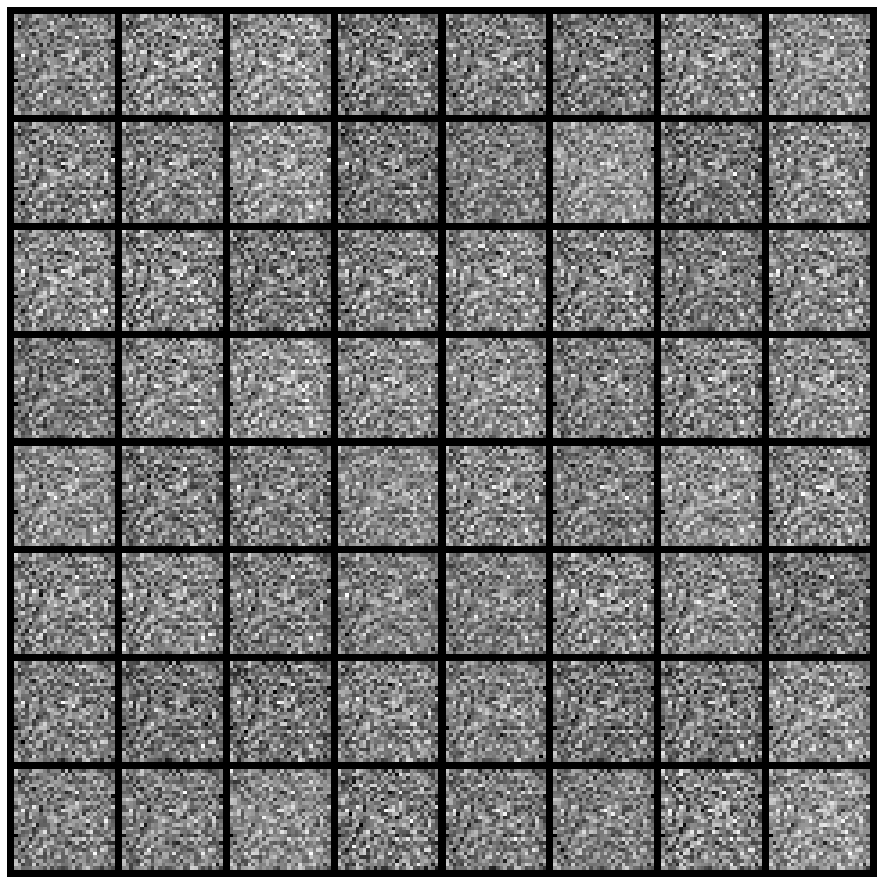

Epoch: [0/300], Batch Num: [0/64]
Discriminator Loss: 1.4117, Generator Loss: 0.7022
D(x): 0.4834, D(G(z)): 0.4951


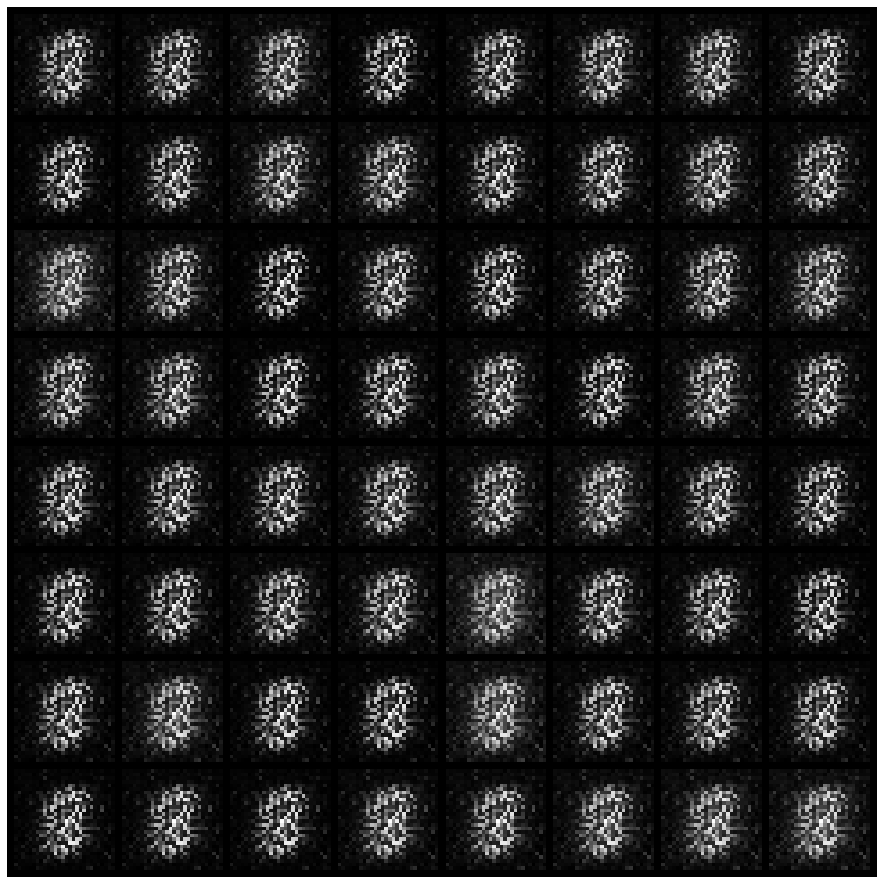

Epoch: [1/300], Batch Num: [0/64]
Discriminator Loss: 0.6169, Generator Loss: 4.4397
D(x): 0.7255, D(G(z)): 0.1364


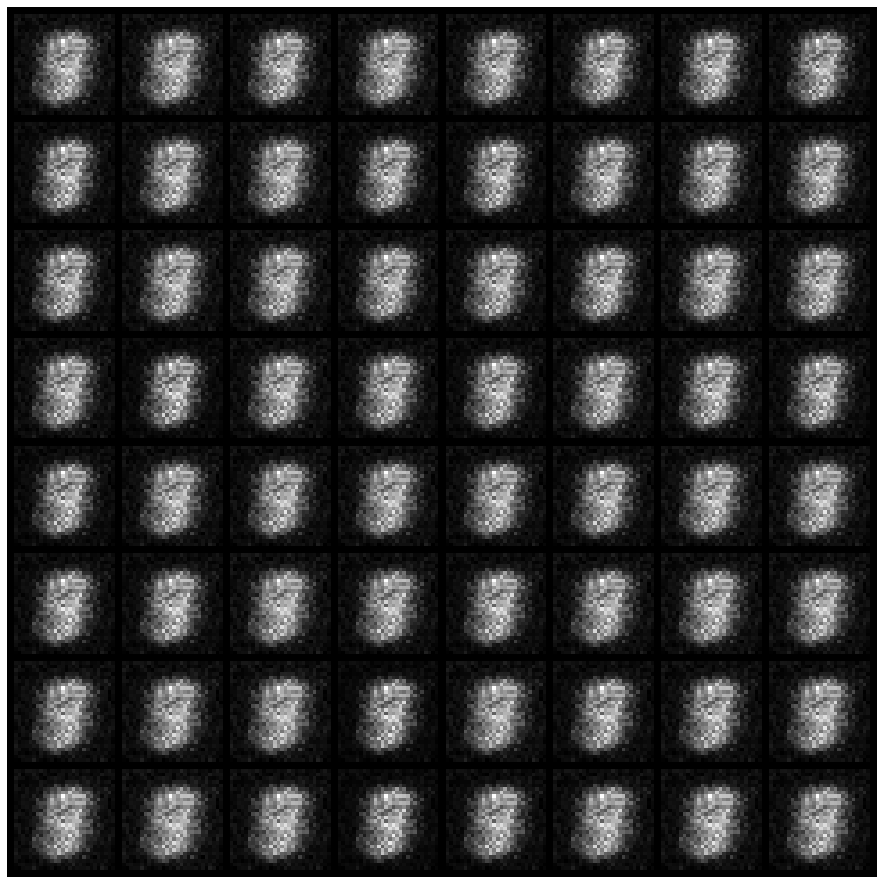

Epoch: [2/300], Batch Num: [0/64]
Discriminator Loss: 0.1990, Generator Loss: 3.0174
D(x): 0.9494, D(G(z)): 0.0913


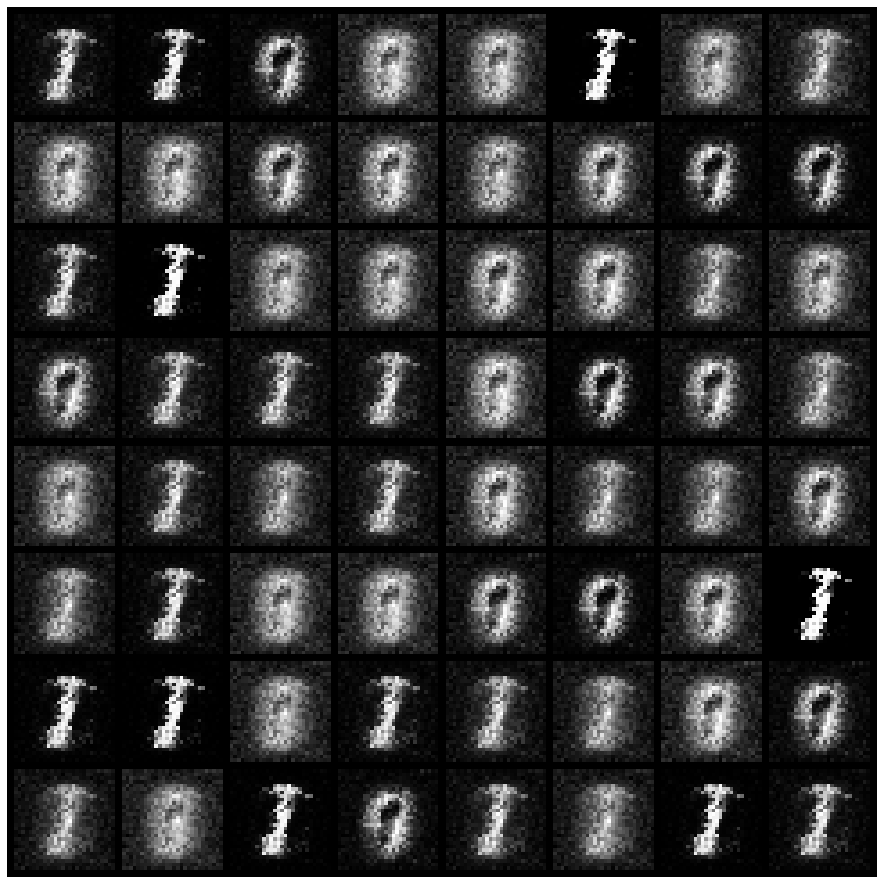

Epoch: [3/300], Batch Num: [0/64]
Discriminator Loss: 0.2761, Generator Loss: 2.8104
D(x): 0.9654, D(G(z)): 0.1566


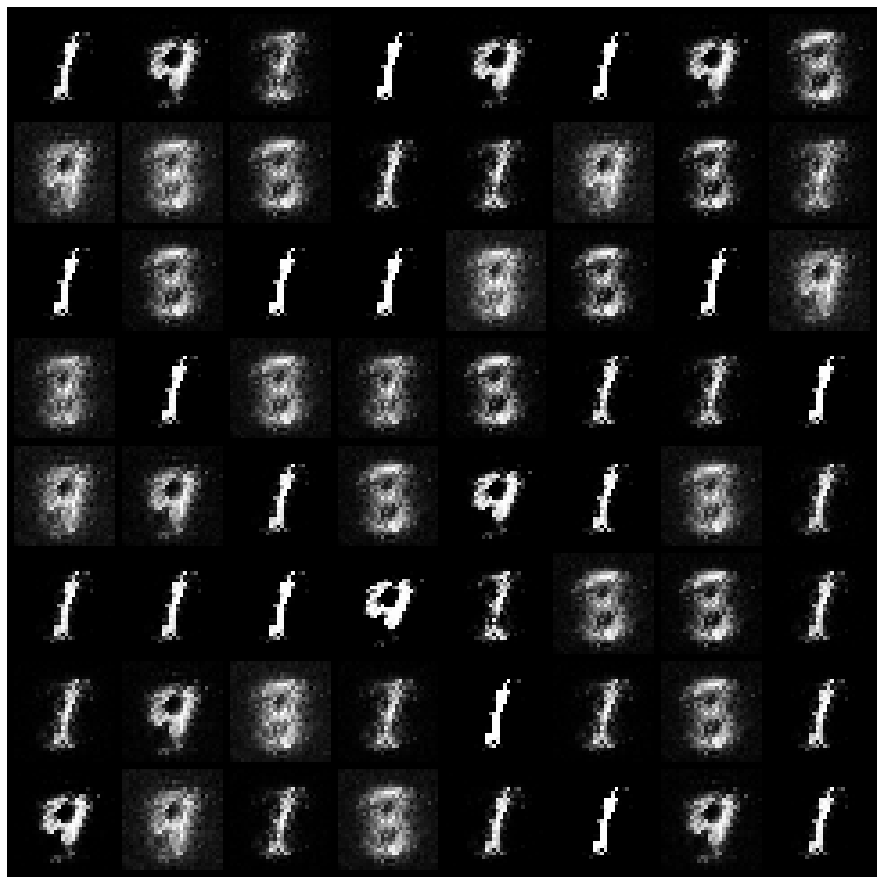

Epoch: [4/300], Batch Num: [0/64]
Discriminator Loss: 0.3129, Generator Loss: 4.9660
D(x): 0.9097, D(G(z)): 0.0502


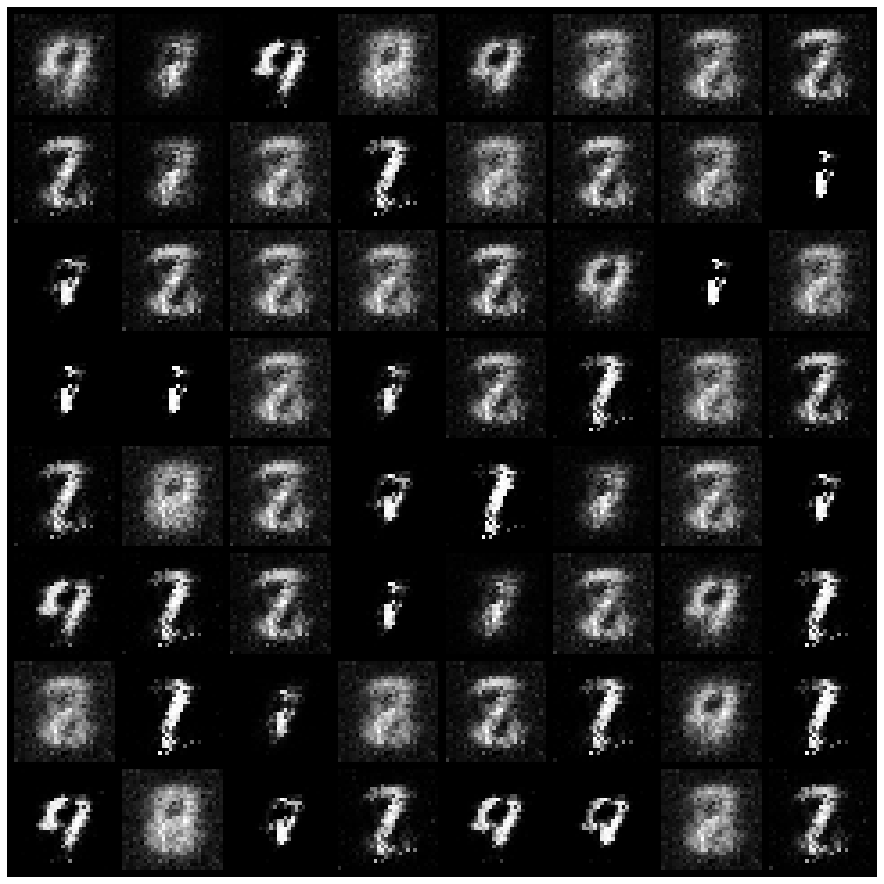

Epoch: [5/300], Batch Num: [0/64]
Discriminator Loss: 0.3875, Generator Loss: 3.8218
D(x): 0.8786, D(G(z)): 0.0903


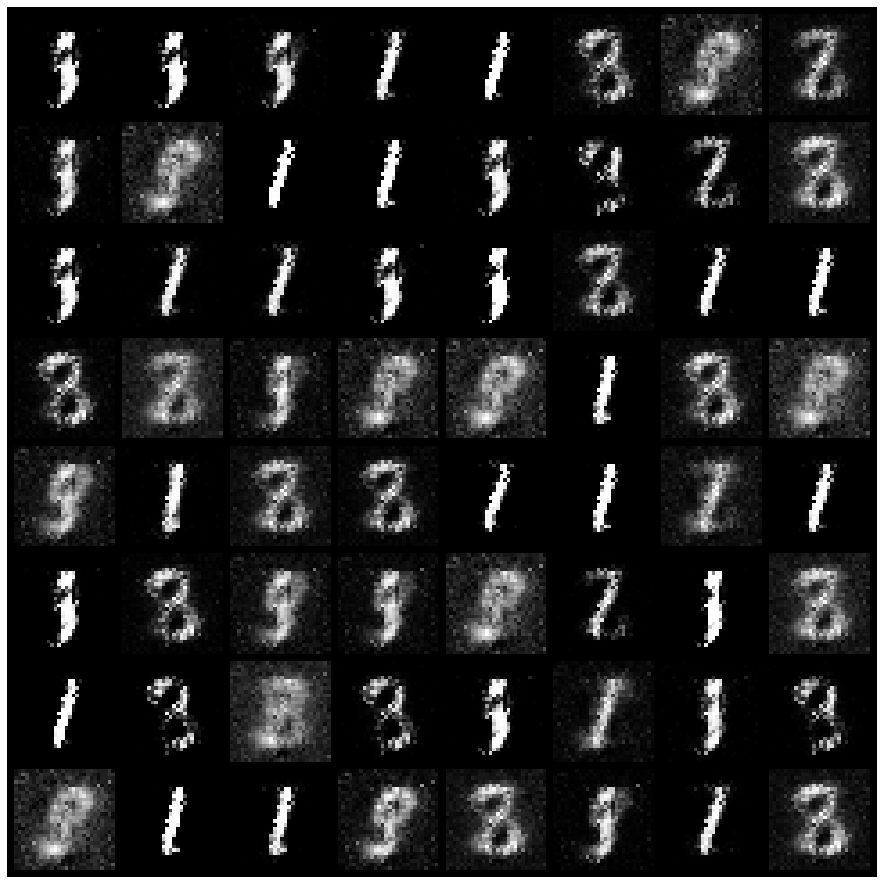

Epoch: [6/300], Batch Num: [0/64]
Discriminator Loss: 0.2193, Generator Loss: 3.8763
D(x): 0.9563, D(G(z)): 0.1027


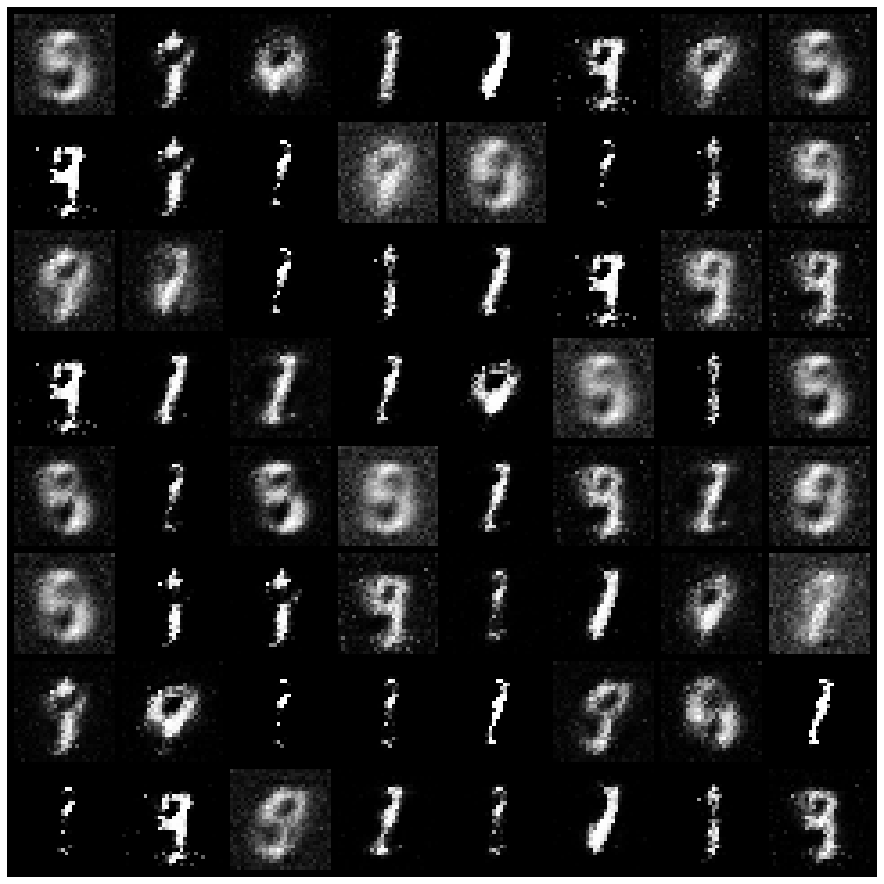

Epoch: [7/300], Batch Num: [0/64]
Discriminator Loss: 0.4228, Generator Loss: 3.1277
D(x): 0.9080, D(G(z)): 0.0922


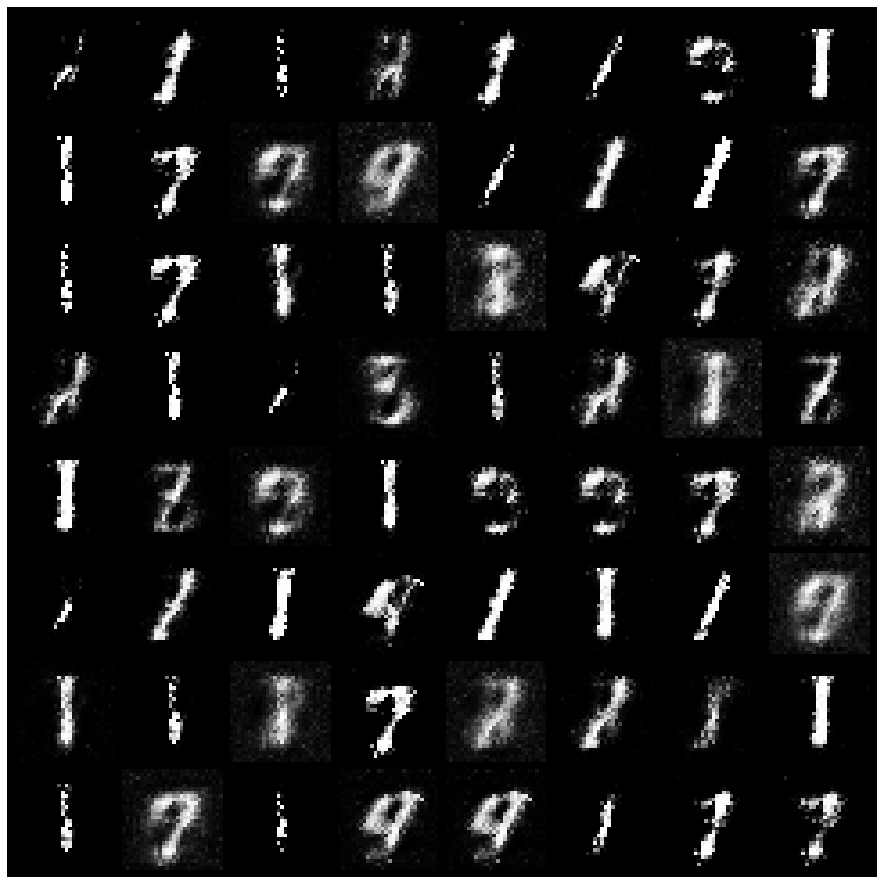

Epoch: [8/300], Batch Num: [0/64]
Discriminator Loss: 0.4098, Generator Loss: 3.0542
D(x): 0.8563, D(G(z)): 0.1207


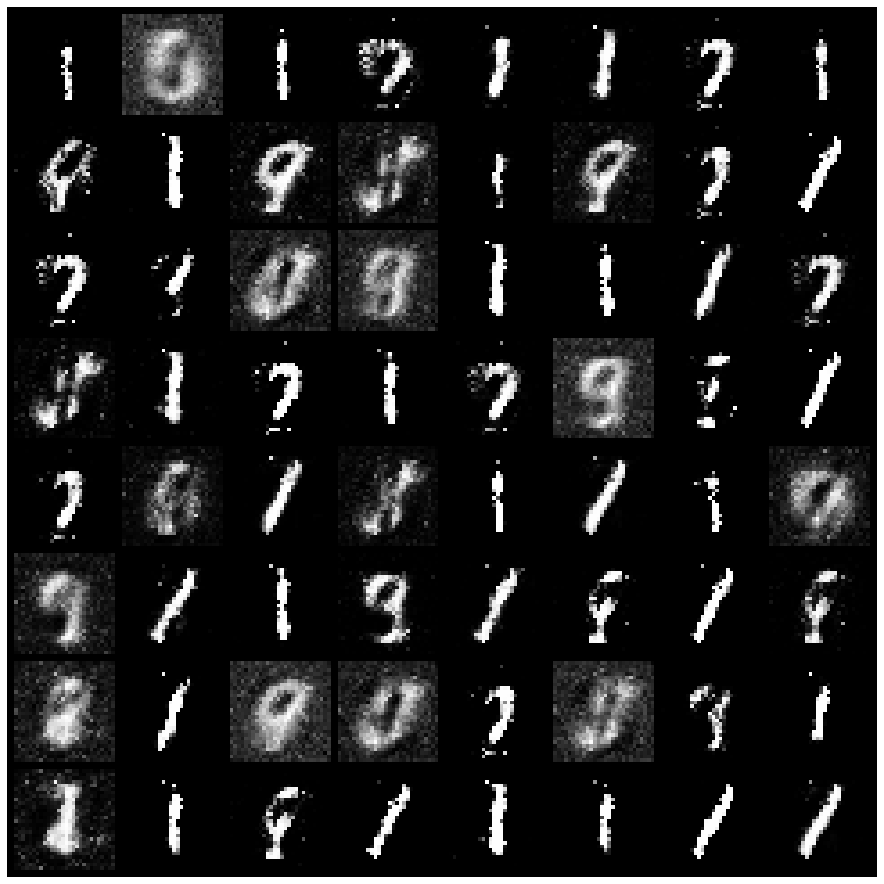

Epoch: [9/300], Batch Num: [0/64]
Discriminator Loss: 0.5034, Generator Loss: 2.6933
D(x): 0.8411, D(G(z)): 0.1329


In [ ]:
logger = Logger(model_name='VGAN', data_name='MNIST')
num_batches = 64
num_test_samples = 16

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(MNIST_loader):

        # Train Discriminator
        real_data = Variable(real_batch.view(real_batch.size(0), 784))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(sample_noise( real_data.size(0), num_batches)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # Train Generator
        # Generate fake data
        fake_data = generator(sample_noise(real_batch.size(0), num_batches))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        if (n_batch) % 1024 == 0: 
            test_images = vectors_to_images(generator(sample_noise(num_batches, 64)))
            test_images = test_images.data
            logger.log_images(test_images, num_test_samples,epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(epoch, num_epochs, n_batch, num_batches,d_error, g_error, d_pred_real, d_pred_fake)

        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)